# Here we compare the dimensions of a regular STFT and the AutoEncoder coding layer

In [40]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import librosa as lib
import soundfile as sf
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from librosa import display

def overlapping(A,B):
    # [T, F]
    A = np.reshape(np.abs(A),(-1))
    B = np.reshape(np.abs(B),(-1))
    measure = 1.0 - np.abs(A-B)/np.amax(np.concatenate((A[:,np.newaxis],B[:,np.newaxis]), 1), -1)
    return np.sum(measure)


DIMENSION OF STFT =  (257, 80)


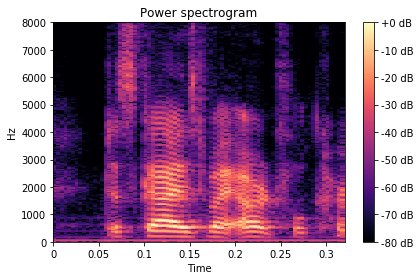

DIMENSION OF STFT =  (257, 80)


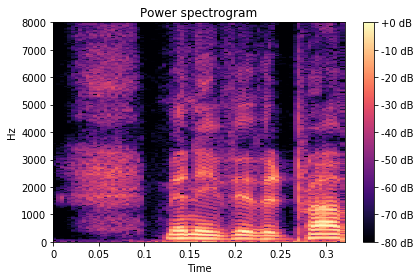

DIMENSION OF STFT =  (257, 80)


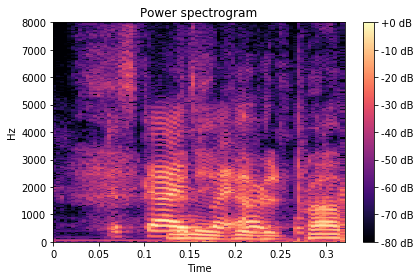

12343.0


In [41]:
signal_woman, fs = sf.read('../original_woman.flac')
signal_woman = signal_woman[0:20240]

signal_man, fs = sf.read('../original_man.flac')
signal_man = signal_man[0:20240]

#Woman
X = lib.core.stft(signal_woman, n_fft=512, hop_length=256)
display.specshow(lib.amplitude_to_db(X,ref=np.max),y_axis='linear', x_axis='time', sr=fs,  hop_length=64)
print 'DIMENSION OF STFT = ', X.shape
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
nb_bins_stft =  X.shape[0]*X.shape[1]

#Man
X1 = lib.core.stft(signal_man, n_fft=512, hop_length=256)
display.specshow(lib.amplitude_to_db(X1,ref=np.max),y_axis='linear', x_axis='time', sr=fs,  hop_length=64)
print 'DIMENSION OF STFT = ', X1.shape
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

#Man + Woman
X2 = lib.core.stft(signal_man+signal_woman, n_fft=512, hop_length=256)
display.specshow(lib.amplitude_to_db(X2,ref=np.max),y_axis='linear', x_axis='time', sr=fs,  hop_length=64)
print 'DIMENSION OF STFT = ', X2.shape
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print overlapping(X1, X2)


In [42]:
N = 512
pooling = 256
window = 1024
T = signal.shape[0]
conv_2d_outputdim = (T, N)
pooling_output = (T/pooling, N)
print pooling_output
nb_bins_autoenc =  T*N/pooling
print nb_bins_autoenc
reduction = float(nb_bins_stft)/float(nb_bins_autoenc)
print reduction, 'times'

(80, 512)
40960
0.501953125 times


In [47]:
import os
import tensorflow as tf
import config

def normalize(x):
    b = 1.0
    a = 0.0
    max_val = np.amax(x,keepdims=True)
    min_val = np.amin(x,keepdims=True)
    A = (b - a)/(max_val - min_val)
    B = b - A * max_val
    return A*x + B

# full_id = "AdaptiveNet-noisy-breeze-3898-N=256--alpha=0.01--batch_size=16--beta=0.05--chunk_size=20480--maxpool=256--optimizer=Adam--reg=0.001--rho=0.01--same_filter=True--smooth_size=10--type=pretraining--window=1024-"
# model_meta_path = os.path.join(config.log_dir, "pretraining", full_id, 'model.ckpt.meta')
# model_path = os.path.join(config.log_dir, "pretraining", full_id, 'model.ckpt')
model_meta_path = "/home/anthony/event/model.ckpt-18000.meta"
model_path = "/home/anthony/event/model.ckpt-18000"
sess = tf.Session()

importer = tf.train.import_meta_graph(model_meta_path)
importer.restore(sess, model_path)

graph = tf.get_default_graph()

ops = graph.get_operations()
pooled = [ v.values()[0] for v in ops if ('MaxPool' in v.name and 'optimize' not in v.name)][0]

mix_in = graph.get_tensor_by_name('mix_input:0')
non_mix_in = graph.get_tensor_by_name('non_mix_input:0')

X_in_w = normalize(signal_woman[np.newaxis, :])
X_in_m = normalize(signal_man[np.newaxis, :])

X_non_in = np.zeros((1,4,20240))
with sess.as_default():
    p_w = sess.run(pooled, feed_dict={mix_in:X_in_w, non_mix_in:X_non_in})
    print p_w.shape
    p_w = p_w[0,:,:,0]
    p_m = sess.run(pooled, feed_dict={mix_in:X_in_m, non_mix_in:X_non_in})
    p_m = p_m[0,:,:,0]
    
# display.specshow(lib.amplitude_to_db(np.transpose(p_w),ref=np.max),y_axis='linear', x_axis='time', sr=fs, hop_length=256)
# plt.title('Power spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.show()

# display.specshow(lib.amplitude_to_db(np.transpose(p_m),ref=np.max),y_axis='linear', x_axis='time', sr=fs, hop_length=256)
# plt.title('Power spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.show()

print overlapping(p_w, p_m)



INFO:tensorflow:Restoring parameters from /home/anthony/event/model.ckpt-18000
(5, 80, 256, 1)
14558.8
